In [1]:
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline

from math import log

import statsmodels.api as sm
pd.options.mode.chained_assignment

'warn'

In [2]:
gdp['gdp'].to_excel('gdp.xlsx')

NameError: name 'gdp' is not defined

In [3]:
#Загрузка данных
file = pd.ExcelFile('data_time_series_2.xlsx')
gdp = file.parse('GDP')
pop = file.parse('Population')
wage = file.parse('Wage', skiprows = 2)

In [4]:
gdp.head()

,Year,gdp_log
0,1870,7.536711
1,1871,7.549297
2,1872,7.639366
3,1873,7.561172
4,1874,7.676581


In [454]:
gdp.shape[0] / 3

50.333333333333336

### Расчёт остатков

In [6]:
from statsmodels.tsa.stattools import adfuller
adfuller(gdp['gdp_log'], regression = 'c')

(-0.2606568570195654,
 0.930894620094759,
 6,
 144,
 {'1%': -3.476597917537401,
  '5%': -2.8818291230495543,
  '10%': -2.5775887982253085},
 -371.20560958216424)

In [602]:
gdp['d1gdp'] = gdp['gdp_log'].diff(periods = 1)
gdp['d2gdp'] = gdp['gdp_log'].diff(periods = 2)
gdp['d3gdp'] = gdp['gdp_log'].diff(periods = 3)
gdp.head()

,Year,gdp,gdp_log,d1gdp,d2gdp,d3gdp
0,1870,1875.650650,7.536711,NaN,NaN,NaN
1,1871,1899.407490,7.549297,0.012586,NaN,NaN
2,1872,2078.426657,7.639366,0.090069,0.102656,NaN
3,1873,1922.096128,7.561172,-0.078195,0.011874,0.024461
4,1874,2157.232468,7.676581,0.115410,0.037215,0.127284


In [16]:
gdp_lags = gdp[['gdp_log']].reset_index(drop = True)

for i in range(1, 2):
    gdp_lags['gdp_log_l'+str(i)] = [0]*i + gdp_lags['gdp_log'][:-i].to_list()
gdp_lags.head(7)

,gdp_log,gdp_log_l1
0,7.536711,0.000000
1,7.549297,7.536711
2,7.639366,7.549297
3,7.561172,7.639366
4,7.676581,7.561172
5,7.704843,7.676581
6,7.614914,7.704843


## Оценка параметров AR(p) модели

In [436]:
gdp

,Year,gdp_log,d1gdp,d2gdp,d3gdp
0,1870,7.536711,NaN,NaN,NaN
1,1871,7.549297,0.012586,NaN,NaN
2,1872,7.639366,0.090069,0.102656,NaN
3,1873,7.561172,-0.078195,0.011874,0.024461
4,1874,7.676581,0.115410,0.037215,0.127284
...,...,...,...,...,...
146,2016,10.009801,0.007600,0.013713,0.018244
147,2017,10.031289,0.021488,0.029087,0.035201
148,2018,10.046363,0.015075,0.036562,0.044162
149,2019,10.062352,0.015989,0.031063,0.052551


### Для ВВП на душу населения

In [7]:
gdp

,Year,gdp_log,d1gdp,d2gdp,d3gdp
0,1870,7.536711,NaN,NaN,NaN
1,1871,7.549297,0.012586,NaN,NaN
2,1872,7.639366,0.090069,0.102656,NaN
3,1873,7.561172,-0.078195,0.011874,0.024461
4,1874,7.676581,0.115410,0.037215,0.127284
...,...,...,...,...,...
146,2016,10.009801,0.007600,0.013713,0.018244
147,2017,10.031289,0.021488,0.029087,0.035201
148,2018,10.046363,0.015075,0.036562,0.044162
149,2019,10.062352,0.015989,0.031063,0.052551


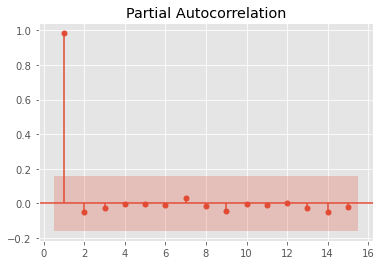

In [9]:
sm.graphics.tsa.plot_pacf(gdp_lags['gdp_log'], method='ywm', zero=False, alpha=0.05, lags = 15)
plt.show()

In [18]:
x1_gdp = pd.DataFrame(gdp_lags['gdp_log_l1'])
y1_gdp = gdp_lags['gdp_log']
x1_const_gdp = sm.tools.tools.add_constant(x1_gdp, prepend = True, has_constant = 'skip')

C:\Users\Olga\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


In [19]:
#Строим модель
gdp_model = sm.OLS(y1_gdp, x1_const_gdp)
gdp_result = gdp_model.fit()
print(gdp_result.summary())

                            OLS Regression Results                            
Dep. Variable:                gdp_log   R-squared:                       0.693
Model:                            OLS   Adj. R-squared:                  0.691
Method:                 Least Squares   F-statistic:                     336.7
Date:                Fri, 27 Jan 2023   Prob (F-statistic):           4.59e-40
Time:                        13:33:27   Log-Likelihood:                -100.48
No. Observations:                 151   AIC:                             205.0
Df Residuals:                     149   BIC:                             211.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.1589      0.306     10.330      0.0

In [11]:
np.sqrt(gdp_result.scale)

0.4747435157201114

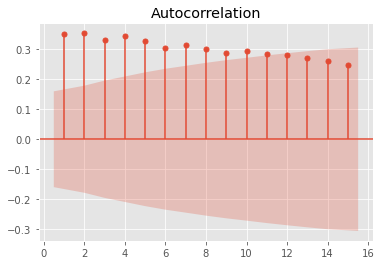

In [20]:
sm.graphics.tsa.plot_acf(gdp_result.resid, zero = False, alpha = 0.05, lags = 15)
plt.show()

In [21]:
lag = int(log(len(gdp_result.resid)))
sm.stats.acorr_ljungbox(gdp_result.resid, lags=[lag], model_df = 1, return_df = True)

,lb_stat,lb_pvalue
5,90.622757,9.709705e-19


In [25]:
adfuller(gdp['d1gdp'][1:], regression = 'c')

(-6.226413738804385,
 5.0758816602991544e-08,
 5,
 144,
 {'1%': -3.476597917537401,
  '5%': -2.8818291230495543,
  '10%': -2.5775887982253085},
 -369.6340784690319)

In [27]:

d1_gdp

,d1gdp
0,0.012586
1,0.090069
2,-0.078195
3,0.115410
4,0.028262
...,...
145,0.007600
146,0.021488
147,0.015075
148,0.015989


In [29]:
d1_gdp = pd.DataFrame(gdp[['d1gdp']][1:].reset_index(drop=True))
for i in range(1, 7):
    d1_gdp['d1_gdp_l' + str(i)] = [0]*i + d1_gdp['d1gdp'][:-i].tolist()

d1_gdp

,d1gdp,d1_gdp_l1,d1_gdp_l2,d1_gdp_l3,d1_gdp_l4,d1_gdp_l5,d1_gdp_l6
0,0.012586,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.090069,0.012586,0.000000,0.000000,0.000000,0.000000,0.000000
2,-0.078195,0.090069,0.012586,0.000000,0.000000,0.000000,0.000000
3,0.115410,-0.078195,0.090069,0.012586,0.000000,0.000000,0.000000
4,0.028262,0.115410,-0.078195,0.090069,0.012586,0.000000,0.000000
...,...,...,...,...,...,...,...
145,0.007600,0.006113,0.004531,0.001061,-0.001105,0.016841,0.010921
146,0.021488,0.007600,0.006113,0.004531,0.001061,-0.001105,0.016841
147,0.015075,0.021488,0.007600,0.006113,0.004531,0.001061,-0.001105
148,0.015989,0.015075,0.021488,0.007600,0.006113,0.004531,0.001061


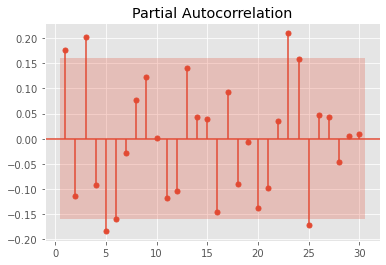

In [31]:
sm.graphics.tsa.plot_pacf(d1_gdp['d1gdp'], method = 'ywm', zero = False, alpha = 0.05, lags = 30)
plt.show()

In [32]:
d1gdp_l1 = d1_gdp[['d1gdp', 'd1_gdp_l1']][1:].reset_index(drop = True)
X_1_gdp_diff = d1gdp_l1.drop('d1gdp', axis = 1)
Y_1_gdp_diff = d1gdp_l1['d1gdp']
X_1_gdp_diff_c = sm.tools.tools.add_constant(X_1_gdp_diff, prepend = True, has_constant = 'skip')

gdp_diff_model = sm.OLS(Y_1_gdp_diff, X_1_gdp_diff_c)
gdp_diff_result = gdp_diff_model.fit()
print(gdp_diff_result.summary())

                            OLS Regression Results                            
Dep. Variable:                  d1gdp   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     4.772
Date:                Fri, 27 Jan 2023   Prob (F-statistic):             0.0305
Time:                        13:51:22   Log-Likelihood:                 200.05
No. Observations:                 149   AIC:                            -396.1
Df Residuals:                     147   BIC:                            -390.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0133      0.005      2.459      0.0

C:\Users\Olga\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


In [21]:
np.sqrt(gdp_diff_result.scale)

0.06362161830026579

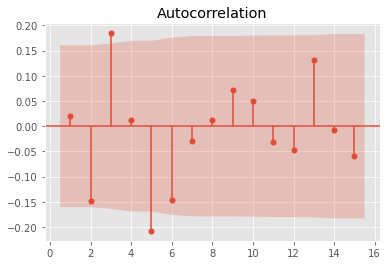

In [33]:
sm.graphics.tsa.plot_acf(gdp_diff_result.resid, zero = False, alpha = 0.05, lags = 15)
plt.show()

In [34]:
lag = int(log(len(gdp_diff_result.resid)))
sm.stats.acorr_ljungbox(gdp_diff_result.resid, lags=[lag], model_df = 1, return_df = True)

,lb_stat,lb_pvalue
5,15.42818,0.003891


### AR (3) для delta Y

In [41]:
d1gdp_l3

,d1gdp,d1_gdp_l1,d1_gdp_l2,d1_gdp_l3
3,0.115410,-0.078195,0.090069,0.012586
4,0.028262,0.115410,-0.078195,0.090069
5,-0.089930,0.028262,0.115410,-0.078195
6,0.047781,-0.089930,0.028262,0.115410
7,-0.017236,0.047781,-0.089930,0.028262
...,...,...,...,...
145,0.007600,0.006113,0.004531,0.001061
146,0.021488,0.007600,0.006113,0.004531
147,0.015075,0.021488,0.007600,0.006113
148,0.015989,0.015075,0.021488,0.007600


In [585]:
d1gdp_l3 = d1_gdp.iloc[3:, 0:4]
X_3_gdp_diff = d1gdp_l3.drop('d1gdp', axis = 1)
Y_3_gdp_diff = d1gdp_l3['d1gdp']
X_3_gdp_diff_c = sm.tools.tools.add_constant(X_3_gdp_diff, prepend = True, has_constant = 'skip')

gdp_diff_model3 = sm.OLS(Y_3_gdp_diff, X_3_gdp_diff_c)
gdp_diff_result3 = gdp_diff_model3.fit(disp=-1)
print(gdp_diff_result3.summary())

                            OLS Regression Results                            
Dep. Variable:                  d1gdp   R-squared:                       0.093
Model:                            OLS   Adj. R-squared:                  0.074
Method:                 Least Squares   F-statistic:                     4.911
Date:                Sun, 29 Jan 2023   Prob (F-statistic):            0.00281
Time:                        16:31:39   Log-Likelihood:                 202.97
No. Observations:                 147   AIC:                            -397.9
Df Residuals:                     143   BIC:                            -386.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0117      0.006      2.118      0.0

C:\Users\Olga\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


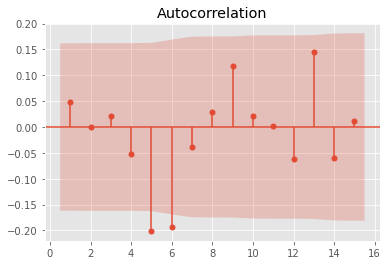

In [586]:
sm.graphics.tsa.plot_acf(gdp_diff_result3.resid, zero = False, alpha = 0.05, lags = 15)
plt.show()

In [587]:
lag = int(log(len(gdp_diff_result3.resid)))
sm.stats.acorr_ljungbox(gdp_diff_result3.resid, lags=[lag], model_df = 3, return_df = True)

,lb_stat,lb_pvalue
4,0.844868,0.358008


In [1257]:
gdp_fc = gdp_diff_result3.get_prediction().summary_frame()[:50]
gdp_fc.head()

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
3,-0.019012,0.011909,-0.042553,0.004528,-0.143174,0.105149
4,0.070899,0.015571,0.040119,0.101678,-0.054836,0.196634
5,-0.016699,0.013116,-0.042625,0.009226,-0.141335,0.107936
6,0.009787,0.012246,-0.014419,0.033993,-0.114502,0.134076
7,0.043666,0.011105,0.021714,0.065617,-0.080204,0.167536


<ipython-input-1254-d7d5c26b1b65>:1: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdp_k = gdp['gdp_log'].tail(1).append(gdp_fc['mean'], ignore_index=True)
<ipython-input-1254-d7d5c26b1b65>:6: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdp_up = gdp['gdp_log'].tail(1).append(gdp_fc['mean_ci_upper'], ignore_index=True)
<ipython-input-1254-d7d5c26b1b65>:11: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdp_low = gdp['gdp_log'].tail(1).append(gdp_fc['mean_ci_lower'], ignore_index=True)


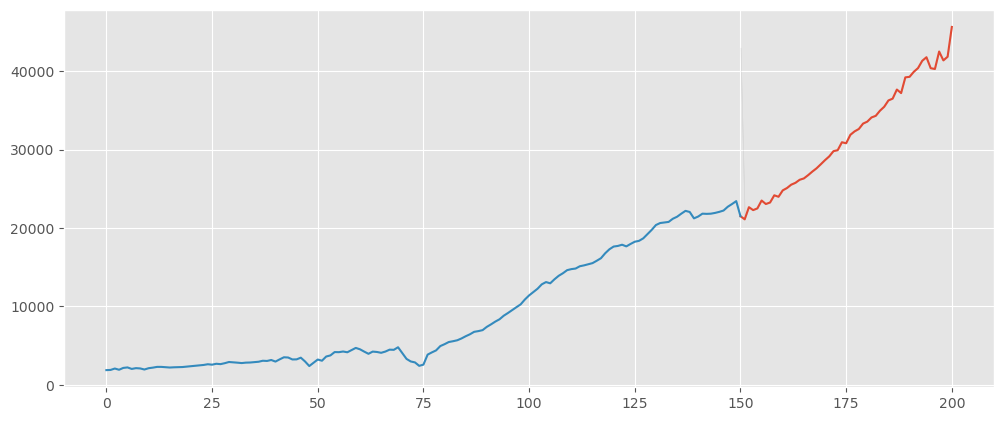

In [1254]:
gdp_k = gdp['gdp_log'].tail(1).append(gdp_fc['mean'], ignore_index=True)
gdp_forecast = gdp_k.cumsum().apply(lambda x: exp(x))
gdp_forecast = gdp_forecast.to_frame()
gdp_forecast = gdp_forecast.set_index(pd.Series([i for i in range(150, 201)]))

gdp_up = gdp['gdp_log'].tail(1).append(gdp_fc['mean_ci_upper'], ignore_index=True)
gdp_up = gdp_up.apply(lambda x: exp(x))
gdp_up = gdp_up.to_frame()
gdp_up = gdp_up.set_index(pd.Series([i for i in range(150, 201)]))

gdp_low = gdp['gdp_log'].tail(1).append(gdp_fc['mean_ci_lower'], ignore_index=True)
gdp_low = gdp_low.apply(lambda x: exp(x))
gdp_low = gdp_low.to_frame()
gdp_low = gdp_low.set_index(pd.Series([i for i in range(150, 201)]))

plt.figure(figsize=(12,5), dpi=100)
plt.plot(gdp_forecast, label='forecast')
plt.plot(gdp['gdp'], label='actual')
plt.fill_between(gdp_low.index, gdp_forecast[0]+gdp_low[0], gdp_forecast[0]+gdp_up[0], color='k', alpha=0.05)
plt.show()

In [1255]:
(gdp_forecast[0]+gdp_low[0])

150    43051.899930
151    21121.514393
152    22673.373778
153    22297.823577
154    22517.140839
155    23522.144395
156    23078.163065
157    23268.280995
158    24188.803804
159    24000.216137
160    24817.940638
161    25114.731317
162    25543.992778
163    25780.038236
164    26169.681587
165    26342.757098
166    26758.303774
167    27216.365219
168    27634.579253
169    28147.946898
170    28676.246692
171    29155.292860
172    29821.820766
173    29948.126638
174    30960.250912
175    30829.421083
176    31910.321538
177    32347.864530
178    32652.843358
179    33339.290660
180    33591.333062
181    34125.014058
182    34330.964459
183    34984.078079
184    35486.010662
185    36294.083558
186    36526.308271
187    37687.352997
188    37231.750508
189    39239.476375
190    39308.746343
191    39947.862316
192    40422.582039
193    41354.701596
194    41809.911643
195    40411.361787
196    40310.197751
197    42538.948499
198    41403.762382
199    41873.870130


### MA(k)-модель

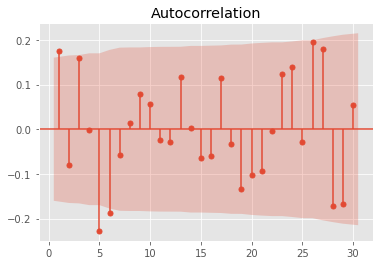

In [44]:
sm.graphics.tsa.plot_acf(gdp['d1gdp'][1:], zero = False, alpha = 0.05, lags = 30) # Строим ACF
plt.show()

In [45]:
from statsmodels.tsa.arima.model import ARIMA

gdp_arima = ARIMA(gdp['d1gdp'][1:], trend = 'c', order = (0, 0, 1))
gdp_arima = gdp_arima.fit()
print(gdp_arima.summary())

                               SARIMAX Results                                
Dep. Variable:                  d1gdp   No. Observations:                  150
Model:                 ARIMA(0, 0, 1)   Log Likelihood                 202.840
Date:                Fri, 27 Jan 2023   AIC                           -399.679
Time:                        14:10:55   BIC                           -390.647
Sample:                             0   HQIC                          -396.010
                                - 150                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0160      0.007      2.363      0.018       0.003       0.029
ma.L1          0.2614      0.050      5.214      0.000       0.163       0.360
sigma2         0.0039      0.000     17.131      0.0

In [46]:
gdp_b0 = 0.016 * (1 - sum(gdp_arima.maparams))
gdp_b0

0.0118179091746744

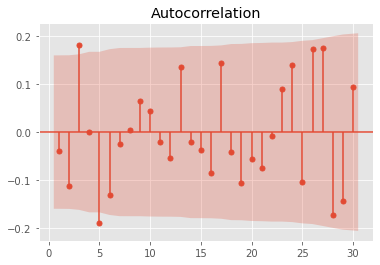

In [47]:
sm.graphics.tsa.plot_acf(gdp_arima.resid, zero = False, alpha = 0.05, lags = 30) # Строим ACF
plt.show()

In [48]:
lag = int(log(len(gdp_arima.resid)))
sm.stats.acorr_ljungbox(gdp_arima.resid, lags=[lag], model_df = 1, return_df = True)

,lb_stat,lb_pvalue
5,13.103068,0.010783


In [546]:
gdp_arima = ARIMA(gdp['d1gdp'][1:], trend = 'c', order = (0, 0, 6))
gdp_arima = gdp_arima.fit()
print(gdp_arima.summary())

                               SARIMAX Results                                
Dep. Variable:                  d1gdp   No. Observations:                  150
Model:                 ARIMA(0, 0, 6)   Log Likelihood                 214.045
Date:                Sun, 29 Jan 2023   AIC                           -412.089
Time:                        16:13:00   BIC                           -388.004
Sample:                             0   HQIC                          -402.304
                                - 150                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0161      0.006      2.724      0.006       0.005       0.028
ma.L1          0.1972      0.053      3.730      0.000       0.094       0.301
ma.L2         -0.0653      0.071     -0.917      0.3

C:\Users\Olga\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


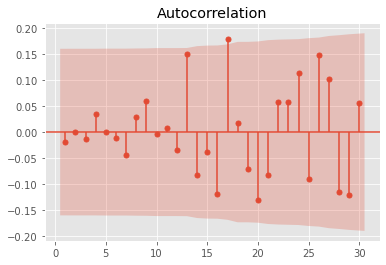

In [50]:
sm.graphics.tsa.plot_acf(gdp_arima.resid, zero = False, alpha = 0.05, lags = 30) # Строим ACF
plt.show()

In [1259]:
lag = int(log(len(gdp_arima.resid)))
sm.stats.acorr_ljungbox(gdp_arima.resid, lags=[7], model_df = 6, return_df = True)

AttributeError: module 'statsmodels.tsa' has no attribute 'stats'

In [1262]:
gdp_arima.get_prediction().summary_frame()[['mean', 'mean_ci_lower', 'mean_ci_upper']].to_excel('MA6_gdp.xlsx')

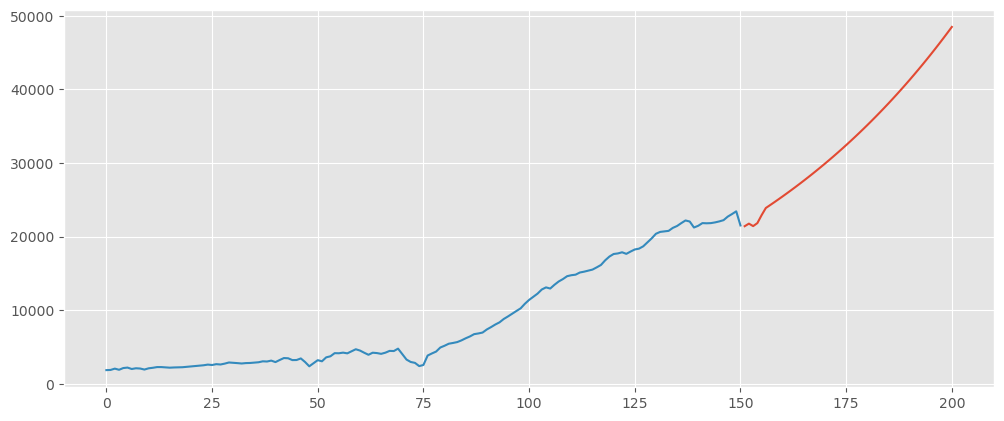

In [1199]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(gdp_forecast['mean'], label='forecast')
plt.plot(gdp['gdp'], label='actual')
plt.fill_between(gdp_forecast.index)
plt.show()

### ARMA (p,k)

In [388]:
!pip install pmdarima

  Using cached pmdarima-2.0.2-cp38-cp38-win_amd64.whl (571 kB)


In [404]:
import pmdarima
pmdarima.arima.auto_arima(gdp['d1gdp'][1:], start_q = 0, max_q = 0, seasonal=False, test = 'adf')

ARIMA(order=(3, 0, 0), scoring_args={}, suppress_warnings=True)

In [603]:
sm.tsa.stattools.arma_order_select_ic(gdp['d1gdp'][1:], max_ar = 8, max_ma = 8, trend = 'c')

C:\Users\Olga\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

C:\Users\Olga\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed

C:\Users\Olga\anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:1451: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(self._index, pd.Int64Index):
C:\Users\Olga\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.t

C:\Users\Olga\anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:1451: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(self._index, pd.Int64Index):
C:\Users\Olga\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.t

C:\Users\Olga\anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:1451: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(self._index, pd.Int64Index):
C:\Users\Olga\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.t

C:\Users\Olga\anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:1451: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(self._index, pd.Int64Index):
C:\Users\Olga\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.t

C:\Users\Olga\anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:1451: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(self._index, pd.Int64Index):
C:\Users\Olga\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.t

{'bic':             0           1           2           3           4          5  \
 0 -388.973247 -390.647208 -389.118629 -388.272315 -384.926132 -387.32555   
 1 -388.722174         NaN         NaN         NaN         NaN        NaN   
 2 -385.747419         NaN         NaN         NaN         NaN        NaN   
 3 -387.435842         NaN         NaN         NaN         NaN        NaN   
 4 -384.189991         NaN         NaN         NaN         NaN        NaN   
 5 -383.769133         NaN         NaN         NaN         NaN        NaN   
 6 -382.348444         NaN         NaN         NaN         NaN        NaN   
 7 -377.441990         NaN         NaN         NaN         NaN        NaN   
 8 -373.492322         NaN         NaN         NaN         NaN        NaN   
 
             6           7           8  
 0 -388.004587 -383.775844 -378.819114  
 1         NaN         NaN         NaN  
 2         NaN         NaN         NaN  
 3         NaN         NaN         NaN  
 4         NaN  

In [798]:
arima_gdp_model = ARIMA(gdp['d1gdp'][1:], trend = 'c', order = (5,0,1))
arima_gdp_model = arima_gdp_model.fit()
print(arima_gdp_model.summary())

                               SARIMAX Results                                
Dep. Variable:                  d1gdp   No. Observations:                  150
Model:                 ARIMA(5, 0, 1)   Log Likelihood                 210.539
Date:                Sun, 29 Jan 2023   AIC                           -405.078
Time:                        17:52:02   BIC                           -380.993
Sample:                             0   HQIC                          -395.293
                                - 150                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0161      0.006      2.674      0.007       0.004       0.028
ar.L1          0.6096      0.328      1.861      0.063      -0.033       1.252
ar.L2         -0.2276      0.109     -2.080      0.0

C:\Users\Olga\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [613]:
const = 0.0158 * (1 - sum(arima_gdp_model.arparams))/(1 + sum(arima_gdp_model.maparams))
const

0.013151295206599117

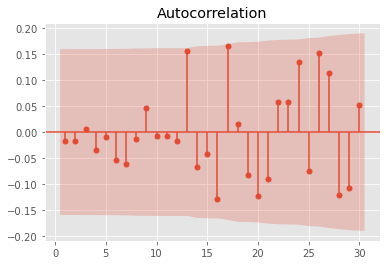

In [614]:
sm.graphics.tsa.plot_acf(arima_gdp_model.resid, zero = False, alpha = 0.05, lags = 30)
plt.show()

In [615]:
lag = int(log(len(arima_gdp_model.resid))) 
sm.stats.acorr_ljungbox(arima_gdp_model.resid, lags = [7], model_df = 6, return_df = True)

,lb_stat,lb_pvalue
7,1.377088,0.240598


In [1263]:
arima_gdp_model.get_prediction().summary_frame()[['mean', 'mean_ci_lower', 'mean_ci_upper']].to_excel('MA6_gdp.xlsx')

<ipython-input-1056-39410a59ba71>:2: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdp_k = gdp['gdp_log'].tail(1).append(gdp_fc['mean'], ignore_index=True)


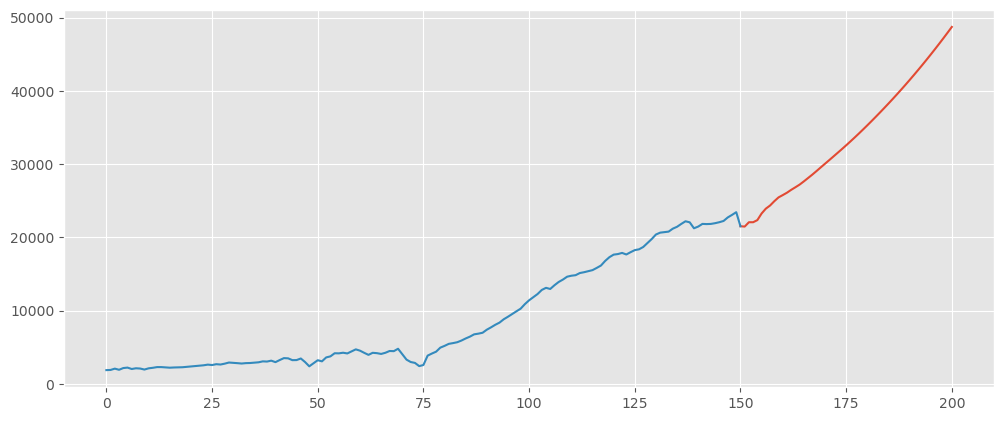

In [1056]:
gdp_fc = arima_gdp_model.get_forecast(steps=50).summary_frame()
gdp_k = gdp['gdp_log'].tail(1).append(gdp_fc['mean'], ignore_index=True)
gdp_forecast = gdp_k.cumsum().apply(lambda x: exp(x))
gdp_forecast = gdp_forecast.to_frame()
gdp_forecast = gdp_forecast.set_index(pd.Series([i for i in range(150, 201)]))


plt.figure(figsize=(12,5), dpi=100)
plt.plot(gdp_forecast, label='forecast')
plt.plot(gdp['gdp'], label='actual')
plt.show()

<ipython-input-1108-64281c049982>:1: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdp_k = gdp['gdp_log'].tail(1).append(gdp_fc['mean'], ignore_index=True)
<ipython-input-1108-64281c049982>:8: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdp_up = pd.Series([0]).append(gdp_up, ignore_index=True)
<ipython-input-1108-64281c049982>:14: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdp_low = pd.Series([0]).append(gdp_low, ignore_index=True)


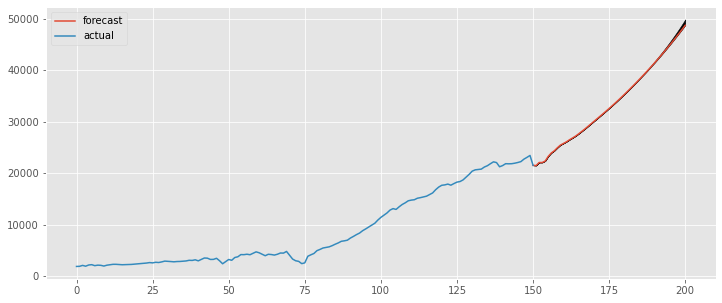

In [1108]:
gdp_k = gdp['gdp_log'].tail(1).append(gdp_fc['mean'], ignore_index=True)
gdp_forecast = gdp_k.cumsum().apply(lambda x: exp(x))
gdp_forecast = gdp_forecast.to_frame()
gdp_forecast = gdp_forecast.set_index(pd.Series([i for i in range(150, 201)]))

gdp_up = gdp_fc['mean_ci_upper']
gdp_up = gdp_up.cumsum().apply(lambda x: exp(x))
gdp_up = pd.Series([0]).append(gdp_up, ignore_index=True)
gdp_up = gdp_up.to_frame()
gdp_up = gdp_up.set_index(pd.Series([i for i in range(150, 201)]))

gdp_low = gdp_fc['mean_ci_lower']
gdp_low = gdp_low.cumsum().apply(lambda x: float(exp(x)))
gdp_low = pd.Series([0]).append(gdp_low, ignore_index=True)
gdp_low = gdp_low.to_frame()
gdp_low = gdp_low.set_index(pd.Series([i for i in range(150, 201)]))

plt.figure(figsize=(12,5))
plt.plot(gdp_forecast, label='forecast')
plt.plot(gdp['gdp'], label='actual')
plt.fill_between(gdp_forecast.index, gdp_forecast[0]-gdp_low[0], gdp_forecast[0]+gdp_up[0], color = 'k')

plt.legend()
plt.show()

## Population

In [618]:
pop.head()

,Year,pop,pop_log
0,1870,38440.0,10.556854
1,1871,37731.0,10.538237
2,1872,37679.0,10.536858
3,1873,37887.0,10.542363
4,1874,38044.0,10.546499


In [619]:
adfuller(pop['pop_log'][1:], regression = 'c')

(0.903376352956329,
 0.9931342308285647,
 4,
 145,
 {'1%': -3.476273058920005,
  '5%': -2.881687616548444,
  '10%': -2.5775132580261593},
 -1034.1376439083035)

In [620]:
pop['d1pop_log'] = pop['pop_log'].diff(periods = 1)
pop['d2pop_log'] = pop['pop_log'].diff(periods = 2)
pop

,Year,pop,pop_log,d1pop_log,d2pop_log
0,1870,38440.000000,10.556854,NaN,NaN
1,1871,37731.000000,10.538237,-0.018617,NaN
2,1872,37679.000000,10.536858,-0.001379,-0.019996
3,1873,37887.000000,10.542363,0.005505,0.004126
4,1874,38044.000000,10.546499,0.004135,0.009640
...,...,...,...,...,...
146,2016,66604.443389,11.106527,0.004048,0.008971
147,2017,66639.495647,11.107053,0.000526,0.004574
148,2018,66850.840138,11.110219,0.003166,0.003693
149,2019,66999.296757,11.112437,0.002218,0.005385


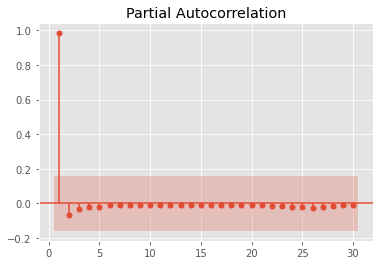

In [621]:
sm.graphics.tsa.plot_pacf(pop['pop_log'], method = 'ywm', zero = False, alpha = 0.05, lags = 30)
plt.show()

In [622]:
pop_log = pd.DataFrame(pop['pop_log'])
for i in range(1,2):
    pop_log['pop_log_l' + str(i)] = [0]*i + pop_log['pop_log'][:-i].tolist()
pop_log.head(7)

,pop_log,pop_log_l1
0,10.556854,0.000000
1,10.538237,10.556854
2,10.536858,10.538237
3,10.542363,10.536858
4,10.546499,10.542363
5,10.551140,10.546499
6,10.555761,10.551140


In [623]:
df_popmodel = pop_log.iloc[1:, :2].reset_index(drop=True)

X1_pop = df_popmodel.drop('pop_log', axis = 1)
Y1_pop = df_popmodel['pop_log']
X1_pop_c = sm.tools.tools.add_constant(X1_pop, prepend = True, has_constant = 'skip')

pop_mod = sm.OLS(Y1_pop, X1_pop_c)
pop_mod = pop_mod.fit()
print(pop_mod.summary())

                            OLS Regression Results                            
Dep. Variable:                pop_log   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 1.072e+05
Date:                Sun, 29 Jan 2023   Prob (F-statistic):          1.41e-213
Time:                        16:44:18   Log-Likelihood:                 532.40
No. Observations:                 150   AIC:                            -1061.
Df Residuals:                     148   BIC:                            -1055.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0836      0.033     -2.523      0.0

C:\Users\Olga\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


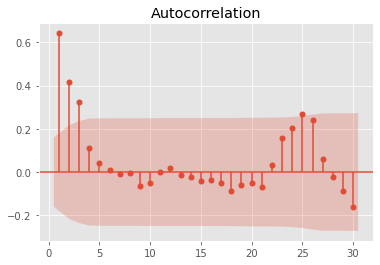

In [624]:
sm.graphics.tsa.plot_acf(pop_mod.resid, zero = False, alpha = 0.05, lags = 30)
plt.show()

In [625]:
lag = int(log(len(pop_mod.resid)))
sm.stats.acorr_ljungbox(pop_mod.resid, lags=[lag], model_df = 1, return_df = True)

,lb_stat,lb_pvalue
5,108.520871,1.504550e-22


In [626]:
adfuller(pop_log['pop_log'], regression = 'c')

(0.9299895681703773,
 0.993469479343224,
 4,
 146,
 {'1%': -3.4759527332353084,
  '5%': -2.881548071241103,
  '10%': -2.577438765246763},
 -1042.8558509576842)

In [627]:
adfuller(pop['d1pop_log'][1:], regression = 'c')

(-4.742508653389177,
 6.996823359150969e-05,
 3,
 146,
 {'1%': -3.4759527332353084,
  '5%': -2.881548071241103,
  '10%': -2.577438765246763},
 -1035.3520985196046)

## First difference

Сначала пройдись по 1-ому, потом переключи на 4

In [628]:
d1pop_log = pd.DataFrame(pop['d1pop_log'][1:].reset_index(drop=True))

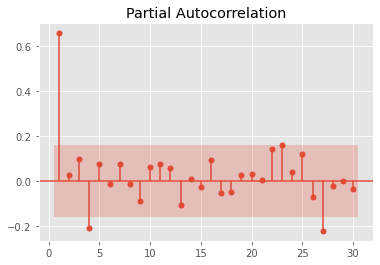

In [629]:
sm.graphics.tsa.plot_pacf(d1pop_log['d1pop_log'], method = 'ywm', zero = False, alpha = 0.05, lags = 30)
plt.show()

In [630]:
for i in range(1, 5):
    d1pop_log['d1pop_log_l' + str(i)] = [0]*i + d1pop_log['d1pop_log'][:-i].tolist()
d1pop_log.head(5)

,d1pop_log,d1pop_log_l1,d1pop_log_l2,d1pop_log_l3,d1pop_log_l4
0,-0.018617,0.000000,0.000000,0.000000,0.000000
1,-0.001379,-0.018617,0.000000,0.000000,0.000000
2,0.005505,-0.001379,-0.018617,0.000000,0.000000
3,0.004135,0.005505,-0.001379,-0.018617,0.000000
4,0.004642,0.004135,0.005505,-0.001379,-0.018617


In [631]:
d1pop_df = d1pop_log.iloc[4:, :5]
d1X1_pop = d1pop_df.drop('d1pop_log', axis = 1)
d1Y1_pop = d1pop_df['d1pop_log']
d1X1_pop_c = sm.tools.tools.add_constant(d1X1_pop, prepend = True, has_constant='skip')
d1popmodel = sm.OLS(d1Y1_pop, d1X1_pop_c)
d1popmodel = d1popmodel.fit()
print(d1popmodel.summary())

                            OLS Regression Results                            
Dep. Variable:              d1pop_log   R-squared:                       0.513
Model:                            OLS   Adj. R-squared:                  0.499
Method:                 Least Squares   F-statistic:                     37.06
Date:                Sun, 29 Jan 2023   Prob (F-statistic):           3.71e-21
Time:                        16:44:33   Log-Likelihood:                 570.64
No. Observations:                 146   AIC:                            -1131.
Df Residuals:                     141   BIC:                            -1116.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0013      0.000      2.603   

C:\Users\Olga\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


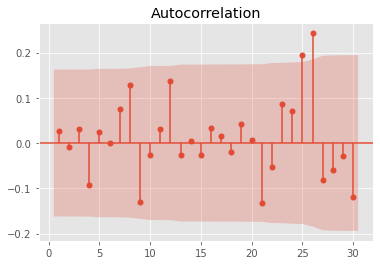

In [632]:
sm.graphics.tsa.plot_acf(d1popmodel.resid, zero = False, alpha = 0.05, lags = 30) # Строим ACF
plt.show()

In [633]:
lag = int(log(len(d1popmodel.resid)))
sm.stats.acorr_ljungbox(d1popmodel.resid, lags=[lag], model_df = 4, return_df = True)

,lb_stat,lb_pvalue
4,1.557989,NaN


In [634]:
lag = 5
sm.stats.acorr_ljungbox(d1popmodel.resid, lags=[lag], model_df = 4, return_df = True)

,lb_stat,lb_pvalue
5,1.652397,0.198633


In [1265]:
d1popmodel.get_prediction().summary_frame()[['mean', 'mean_ci_lower', 'mean_ci_upper']].to_excel('MA4.xlsx')

<ipython-input-796-be9d444988c8>:2: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pop_k = pop['pop_log'].tail(1).append(pop_fc['mean'], ignore_index=True)


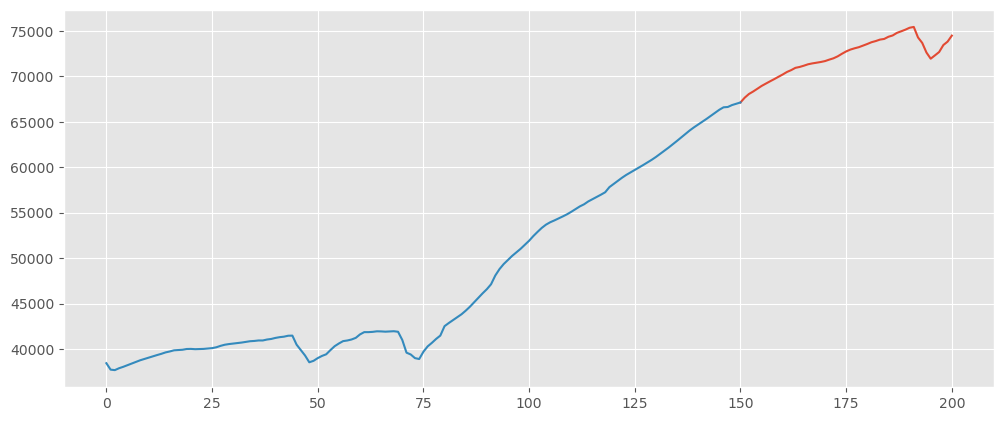

In [796]:

pop_k = pop['pop_log'].tail(1).append(pop_fc['mean'], ignore_index=True)
pop_forecast = pop_k.cumsum().apply(lambda x: exp(x))
pop_forecast = pop_forecast.to_frame()
pop_forecast = pop_forecast.set_index(pd.Series([i for i in range(150, 201)]))


plt.figure(figsize=(12,5), dpi=100)
plt.plot(pop_forecast, label='forecast')
plt.plot(pop['pop'], label='actual')
plt.show()

<ipython-input-1205-6f565e748e14>:2: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pop_k = pop['pop_log'].tail(1).append(pop_fc['mean'], ignore_index=True)
<ipython-input-1205-6f565e748e14>:7: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pop_up = pop['pop_log'].tail(1).append(pop_fc['mean_ci_upper'], ignore_index=True)
<ipython-input-1205-6f565e748e14>:12: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pop_low = pop['pop_log'].tail(1).append(pop_fc['mean_ci_lower'], ignore_index=True)


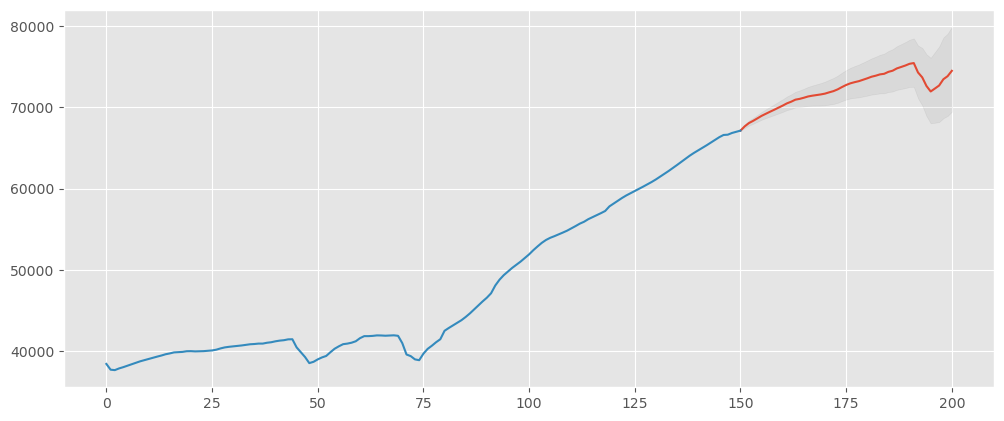

In [1205]:
pop_fc = d1popmodel.get_prediction().summary_frame()[:50]
pop_k = pop['pop_log'].tail(1).append(pop_fc['mean'], ignore_index=True)
pop_forecast = pop_k.cumsum().apply(lambda x: exp(x))
pop_forecast = pop_forecast.to_frame()
pop_forecast = pop_forecast.set_index(pd.Series([i for i in range(150, 201)]))

pop_up = pop['pop_log'].tail(1).append(pop_fc['mean_ci_upper'], ignore_index=True)
pop_up = pop_up.cumsum().apply(lambda x: exp(x))
pop_up = pop_up.to_frame()
pop_up = pop_up.set_index(pd.Series([i for i in range(150, 201)]))

pop_low = pop['pop_log'].tail(1).append(pop_fc['mean_ci_lower'], ignore_index=True)
pop_low = pop_low.cumsum().apply(lambda x: exp(x))
pop_low = pop_low.to_frame()
pop_low = pop_low.set_index(pd.Series([i for i in range(150, 201)]))

plt.figure(figsize=(12,5), dpi=100)
plt.plot(pop_forecast, label='forecast')
plt.plot(pop['pop'], label='actual')
plt.fill_between(pop_low.index, pop_low[0], pop_up[0], color='k', alpha=0.05)
plt.show()

## MA

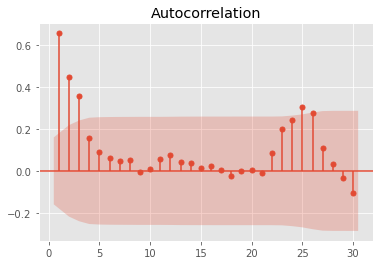

In [643]:
sm.graphics.tsa.plot_acf(pop['d1pop_log'][1:], zero = False, alpha = 0.05, lags = 30)
plt.show()

In [644]:
pop_ma3 = ARIMA(pop['d1pop_log'][1:], trend='c', order=(0, 0, 3))
pop_ma3 = pop_ma3.fit()
print(pop_ma3.summary())

                               SARIMAX Results                                
Dep. Variable:              d1pop_log   No. Observations:                  150
Model:                 ARIMA(0, 0, 3)   Log Likelihood                 577.993
Date:                Sun, 29 Jan 2023   AIC                          -1145.987
Time:                        16:54:13   BIC                          -1130.934
Sample:                             0   HQIC                         -1139.871
                                - 150                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0035      0.001      3.035      0.002       0.001       0.006
ma.L1          0.6991      0.044     15.719      0.000       0.612       0.786
ma.L2          0.3608      0.060      6.038      0.0

In [645]:
const = 0.0035 * (1 - sum(pop_ma3.maparams))
const

-0.0013796010887992068

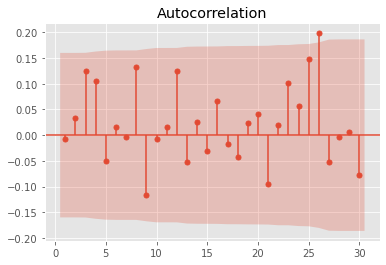

In [646]:
sm.graphics.tsa.plot_acf(pop_ma3.resid, zero = False, alpha = 0.05, lags = 30)
plt.show()

<ipython-input-1206-612aafe61e81>:2: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pop_k = pop['pop_log'].tail(1).append(pop_fc['mean'], ignore_index=True)


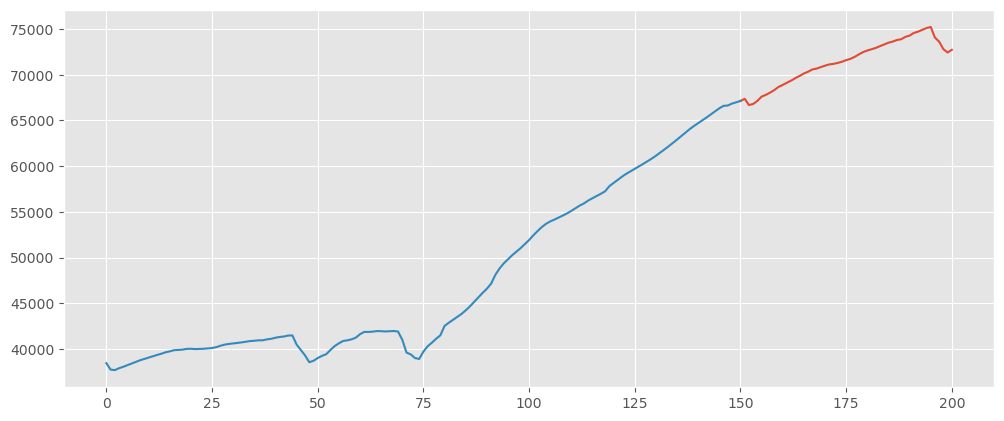

In [1206]:
pop_fc = pop_ma3.get_prediction().summary_frame()[:50]
pop_k = pop['pop_log'].tail(1).append(pop_fc['mean'], ignore_index=True)
pop_forecast = pop_k.cumsum().apply(lambda x: exp(x))
pop_forecast = pop_forecast.to_frame()
pop_forecast = pop_forecast.set_index(pd.Series([i for i in range(150, 201)]))


plt.figure(figsize=(12,5), dpi=100)
plt.plot(pop_forecast, label='forecast')
plt.plot(pop['pop'], label='actual')
plt.show()

<ipython-input-1208-132364aa6931>:2: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pop_k = pop['pop_log'].tail(1).append(pop_fc['mean'], ignore_index=True)
<ipython-input-1208-132364aa6931>:7: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pop_up = pop['pop_log'].tail(1).append(pop_fc['mean_ci_upper'], ignore_index=True)
<ipython-input-1208-132364aa6931>:12: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pop_low = pop['pop_log'].tail(1).append(pop_fc['mean_ci_lower'], ignore_index=True)


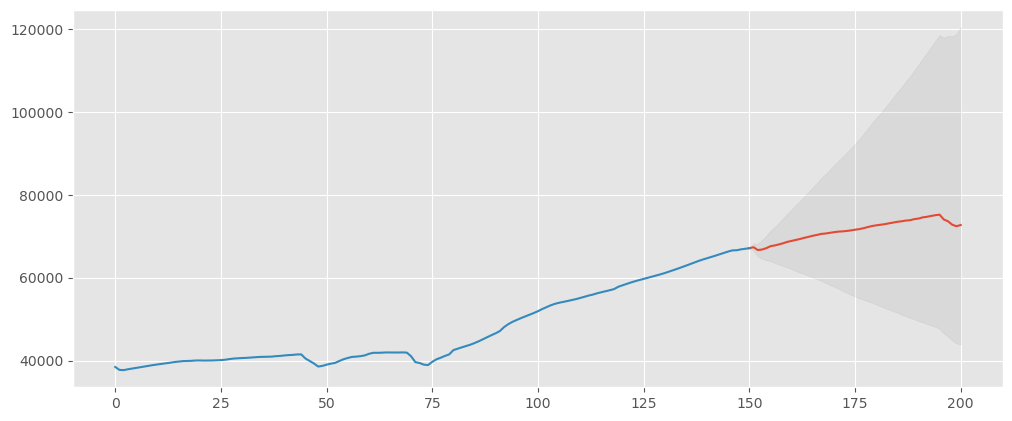

In [1208]:
pop_fc = pop_ma3.get_prediction().summary_frame()[:50]
pop_k = pop['pop_log'].tail(1).append(pop_fc['mean'], ignore_index=True)
pop_forecast = pop_k.cumsum().apply(lambda x: exp(x))
pop_forecast = pop_forecast.to_frame()
pop_forecast = pop_forecast.set_index(pd.Series([i for i in range(150, 201)]))

pop_up = pop['pop_log'].tail(1).append(pop_fc['mean_ci_upper'], ignore_index=True)
pop_up = pop_up.cumsum().apply(lambda x: exp(x))
pop_up = pop_up.to_frame()
pop_up = pop_up.set_index(pd.Series([i for i in range(150, 201)]))

pop_low = pop['pop_log'].tail(1).append(pop_fc['mean_ci_lower'], ignore_index=True)
pop_low = pop_low.cumsum().apply(lambda x: exp(x))
pop_low = pop_low.to_frame()
pop_low = pop_low.set_index(pd.Series([i for i in range(150, 201)]))

plt.figure(figsize=(12,5), dpi=100)
plt.plot(pop_forecast, label='forecast')
plt.plot(pop['pop'], label='actual')
plt.fill_between(pop_low.index, pop_low[0], pop_up[0], color='k', alpha=0.05)
plt.show()

In [1266]:
pop_ma3.get_prediction().summary_frame()[['mean', 'mean_ci_lower', 'mean_ci_upper']].to_excel('MA3pop.xlsx')

# ARIMA

In [412]:
pmdarima.arima.auto_arima(pop['d1pop_log'][1:], start_q = 0, max_q = 0, seasonal=False, test = 'adf')

ARIMA(order=(1, 0, 0), scoring_args={}, suppress_warnings=True)

In [156]:
sm.tsa.stattools.arma_order_select_ic(pop['d1pop_log'][1:], max_ar = 4, max_ma = 4, trend = 'nc') 

C:\Users\Olga\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\Olga\anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:1451: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in 

{'bic':              0            1            2            3            4
 0          NaN -1101.843823 -1106.527448 -1124.746436 -1132.432772
 1 -1136.202470          NaN          NaN          NaN          NaN
 2 -1131.272964          NaN          NaN          NaN          NaN
 3 -1128.217210          NaN          NaN          NaN          NaN
 4 -1129.662338          NaN          NaN          NaN          NaN,
 'bic_min_order': (1, 0)}

In [651]:
pop_arima = ARIMA(pop['d1pop_log'][1:], trend = 'c', order = (1,0,3))
pop_arima = pop_arima.fit()
print(pop_arima.summary())

                               SARIMAX Results                                
Dep. Variable:              d1pop_log   No. Observations:                  150
Model:                 ARIMA(1, 0, 3)   Log Likelihood                 581.205
Date:                Sun, 29 Jan 2023   AIC                          -1150.410
Time:                        16:56:45   BIC                          -1132.346
Sample:                             0   HQIC                         -1143.071
                                - 150                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0034      0.002      2.229      0.026       0.000       0.006
ar.L1          0.4137      0.144      2.865      0.004       0.131       0.697
ma.L1          0.3293      0.144      2.280      0.0

In [652]:
constant = 0.0034 * (1 - sum(pop_arima.arparams))/(1 + sum(pop_arima.maparams))
constant

0.0010845067593071754

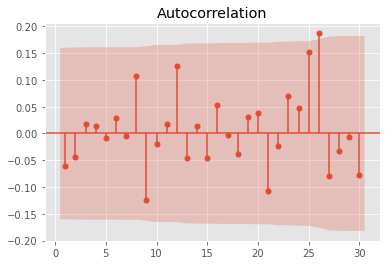

In [653]:
sm.graphics.tsa.plot_acf(pop_arima.resid, zero = False, alpha = 0.05, lags = 30) # Строим ACF
plt.show() # Выводим график

In [654]:
lag = int(log(len(pop_arima.resid)))
sm.stats.acorr_ljungbox(pop_arima.resid, lags = [lag], model_df = 4, return_df = True)

,lb_stat,lb_pvalue
5,0.964628,0.326024


<ipython-input-794-aefb432fad31>:2: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pop_k = pop['pop_log'].tail(1).append(pop_fc['mean'], ignore_index=True)


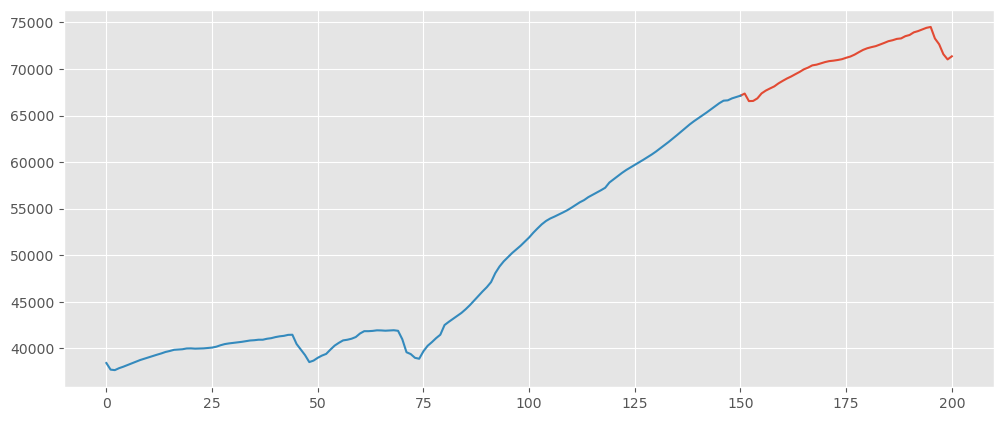

In [794]:
pop_fc = pop_arima.get_prediction().summary_frame()[:50]
pop_k = pop['pop_log'].tail(1).append(pop_fc['mean'], ignore_index=True)
pop_forecast = pop_k.cumsum().apply(lambda x: exp(x))
pop_forecast = pop_forecast.to_frame()
pop_forecast = pop_forecast.set_index(pd.Series([i for i in range(150, 201)]))


plt.figure(figsize=(12,5), dpi=100)
plt.plot(pop_forecast, label='forecast')
plt.plot(pop['pop'], label='actual')
plt.show()

<ipython-input-1209-08add267430c>:2: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pop_k = pop['pop_log'].tail(1).append(pop_fc['mean'], ignore_index=True)
<ipython-input-1209-08add267430c>:7: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pop_up = pop['pop_log'].tail(1).append(pop_fc['mean_ci_upper'], ignore_index=True)
<ipython-input-1209-08add267430c>:12: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pop_low = pop['pop_log'].tail(1).append(pop_fc['mean_ci_lower'], ignore_index=True)


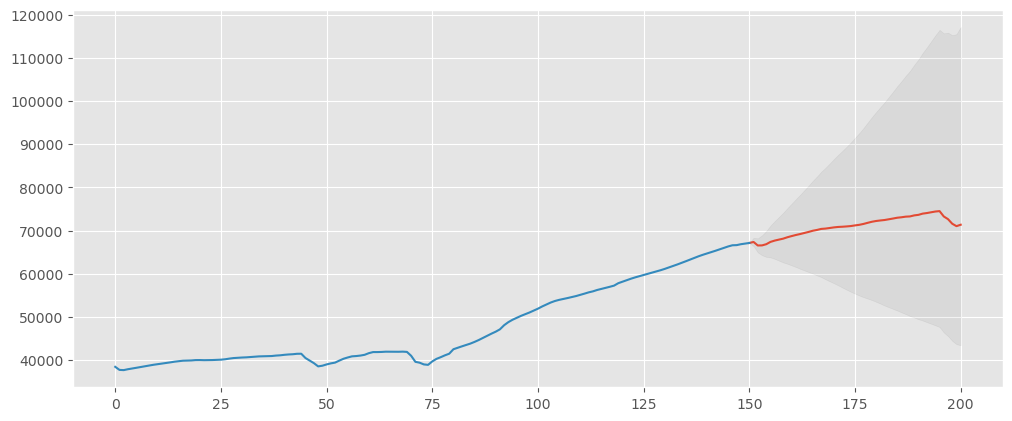

In [1209]:
pop_fc = pop_arima.get_prediction().summary_frame()[:50]
pop_k = pop['pop_log'].tail(1).append(pop_fc['mean'], ignore_index=True)
pop_forecast = pop_k.cumsum().apply(lambda x: exp(x))
pop_forecast = pop_forecast.to_frame()
pop_forecast = pop_forecast.set_index(pd.Series([i for i in range(150, 201)]))

pop_up = pop['pop_log'].tail(1).append(pop_fc['mean_ci_upper'], ignore_index=True)
pop_up = pop_up.cumsum().apply(lambda x: exp(x))
pop_up = pop_up.to_frame()
pop_up = pop_up.set_index(pd.Series([i for i in range(150, 201)]))

pop_low = pop['pop_log'].tail(1).append(pop_fc['mean_ci_lower'], ignore_index=True)
pop_low = pop_low.cumsum().apply(lambda x: exp(x))
pop_low = pop_low.to_frame()
pop_low = pop_low.set_index(pd.Series([i for i in range(150, 201)]))

plt.figure(figsize=(12,5), dpi=100)
plt.plot(pop_forecast, label='forecast')
plt.plot(pop['pop'], label='actual')
plt.fill_between(pop_low.index, pop_low[0], pop_up[0], color='k', alpha=0.05)
plt.show()

In [1269]:
pop['pop'].to_excel('pop.xlsx')

In [1268]:
pop_arima.get_prediction().summary_frame()[['mean', 'mean_ci_lower', 'mean_ci_upper']].to_excel('ARIMApop.xlsx')

# Wage

In [4]:
wage_data = wage['wage_const_season_correct'].to_frame()
wage_data

,wage_const_season_correct
0,27058.832139
1,27434.265426
2,27003.980438
3,26284.908453
4,25131.494568
...,...
161,39114.181373
162,39856.247156
163,40429.374035
164,40206.827759


In [5]:
adfuller(wage_data['wage_const_season_correct'], regression = 'c')

NameError: name 'adfuller' is not defined

In [6]:
wage_data['d1wage'] = wage['wage_const_season_correct'].diff(periods = 1)
wage_data['d2wage'] = wage['wage_const_season_correct'].diff(periods = 2)

In [7]:
wage_data

,wage_const_season_correct,d1wage,d2wage
0,27058.832139,NaN,NaN
1,27434.265426,375.433287,NaN
2,27003.980438,-430.284987,-54.851700
3,26284.908453,-719.071986,-1149.356973
4,25131.494568,-1153.413884,-1872.485870
...,...,...,...
161,39114.181373,225.782704,-1475.306104
162,39856.247156,742.065783,967.848487
163,40429.374035,573.126879,1315.192662
164,40206.827759,-222.546276,350.580603


In [8]:
wagel = wage_data[['wage_const_season_correct']][1:].reset_index(drop = True)
for i in range (1, 14):
     wagel['wage_l' + str(i)] = [0]*i + wagel['wage_const_season_correct'][:-i].tolist()
wagel

,wage_const_season_correct,wage_l1,wage_l2,wage_l3,wage_l4,wage_l5,wage_l6,wage_l7,wage_l8,wage_l9,wage_l10,wage_l11,wage_l12,wage_l13
0,27434.265426,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,27003.980438,27434.265426,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,26284.908453,27003.980438,27434.265426,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,25131.494568,26284.908453,27003.980438,27434.265426,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,26957.620708,25131.494568,26284.908453,27003.980438,27434.265426,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160,39114.181373,38888.398669,40589.487477,40117.075202,40739.517629,41869.004308,42010.551711,40805.400016,41267.724886,40980.378214,40307.691847,40837.726151,40432.921062,41765.116944
161,39856.247156,39114.181373,38888.398669,40589.487477,40117.075202,40739.517629,41869.004308,42010.551711,40805.400016,41267.724886,40980.378214,40307.691847,40837.726151,40432.921062
162,40429.374035,39856.247156,39114.181373,38888.398669,40589.487477,40117.075202,40739.517629,41869.004308,42010.551711,40805.400016,41267.724886,40980.378214,40307.691847,40837.726151
163,40206.827759,40429.374035,39856.247156,39114.181373,38888.398669,40589.487477,40117.075202,40739.517629,41869.004308,42010.551711,40805.400016,41267.724886,40980.378214,40307.691847


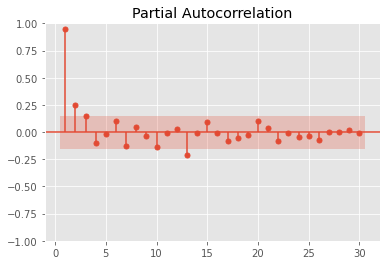

In [9]:
sm.graphics.tsa.plot_pacf(wage_data['wage_const_season_correct'], method = 'ywm', zero = False, alpha = 0.05, lags = 30)
plt.show()

# AR(12)

In [774]:
wage_13 = wagel.iloc[14:, :].reset_index(drop=True)
X13w = wage_13.drop('wage_const_season_correct', axis = 1)
Y13w = wage_13['wage_const_season_correct']
X13w_c = sm.tools.tools.add_constant(X13w, prepend=True, has_constant='skip')

C:\Users\Olga\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


In [775]:
wage_model13 = sm.OLS(Y13w, X13w_c)
wage_model13 = wage_model13.fit()
print(wage_model13.summary())

                                OLS Regression Results                               
Dep. Variable:     wage_const_season_correct   R-squared:                       0.950
Model:                                   OLS   Adj. R-squared:                  0.945
Method:                        Least Squares   F-statistic:                     198.6
Date:                       Sun, 29 Jan 2023   Prob (F-statistic):           5.43e-82
Time:                               17:43:29   Log-Likelihood:                -1228.9
No. Observations:                        151   AIC:                             2486.
Df Residuals:                            137   BIC:                             2528.
Df Model:                                 13                                         
Covariance Type:                   nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------

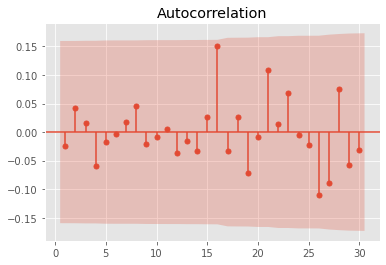

In [776]:
sm.graphics.tsa.plot_acf(wage_model13.resid, zero = False, alpha = 0.05, lags = 30)
plt.show()

In [777]:
lag = int(log(len(wage_model13.resid)))
sm.stats.acorr_ljungbox(wage_model2.resid, lags=[lag], model_df = 13, return_df = True)

,lb_stat,lb_pvalue
5,20.115849,NaN


In [778]:
sm.stats.acorr_ljungbox(wage_model13.resid, lags=[14], model_df = 13, return_df = True)

,lb_stat,lb_pvalue
14,1.925385,0.165264


In [768]:
wage_data

,wage_const_season_correct,d1wage,d2wage
0,27058.832139,NaN,NaN
1,27434.265426,375.433287,NaN
2,27003.980438,-430.284987,-54.851700
3,26284.908453,-719.071986,-1149.356973
4,25131.494568,-1153.413884,-1872.485870
...,...,...,...
161,39114.181373,225.782704,-1475.306104
162,39856.247156,742.065783,967.848487
163,40429.374035,573.126879,1315.192662
164,40206.827759,-222.546276,350.580603


In [781]:
wage_model13 = ARIMA(wage_data['d1wage'][1:], trend = 'c', order=(13, 0, 0)).fit()
print(wage_model13.summary())

                               SARIMAX Results                                
Dep. Variable:                 d1wage   No. Observations:                  165
Model:                ARIMA(13, 0, 0)   Log Likelihood               -1343.881
Date:                Sun, 29 Jan 2023   AIC                           2717.763
Time:                        17:44:13   BIC                           2764.352
Sample:                             0   HQIC                          2736.675
                                - 165                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         95.1992     62.692      1.519      0.129     -27.675     218.073
ar.L1         -0.3896      0.078     -4.966      0.000      -0.543      -0.236
ar.L2         -0.2286      0.098     -2.344      0.0

<ipython-input-785-aa14dfae85b5>:2: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  wage_forecast =  wage_data['wage_const_season_correct'].tail(1).append(wage_fc['mean'], ignore_index=True)


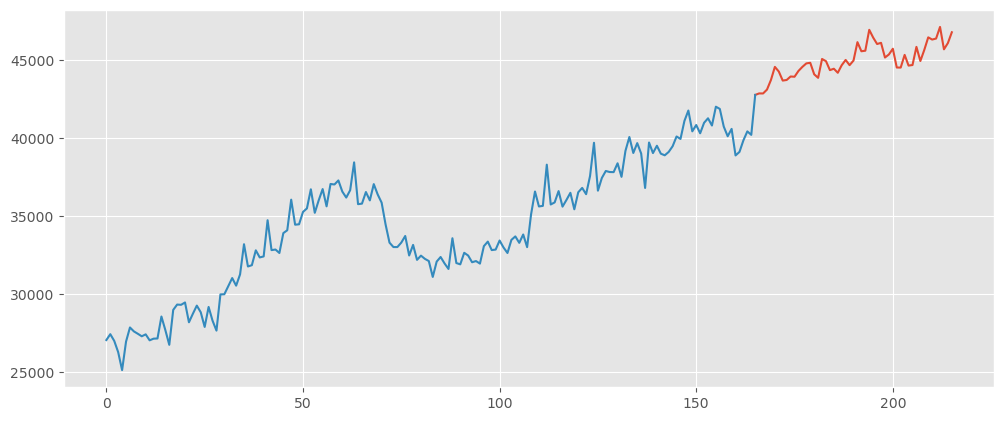

In [785]:
wage_fc = wage_model13.get_prediction().summary_frame()[:50]
wage_forecast =  wage_data['wage_const_season_correct'].tail(1).append(wage_fc['mean'], ignore_index=True)
wage_forecast = wage_forecast.cumsum().to_frame()
wage_forecast = wage_forecast.set_index(pd.Series([i for i in range(165, 216)]))


plt.figure(figsize=(12,5), dpi=100)
plt.plot(wage_forecast, label='forecast')
plt.plot(wage_data['wage_const_season_correct'], label='actual')
plt.show()

<ipython-input-1233-0b63f10ad184>:2: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  wage_forecast =  wage_data['wage_const_season_correct'].tail(1).append(wage_fc['mean'], ignore_index=True)
<ipython-input-1233-0b63f10ad184>:6: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  wage_up=  wage_data['wage_const_season_correct'].tail(1).append(wage_fc['mean_ci_upper'], ignore_index=True)
<ipython-input-1233-0b63f10ad184>:10: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  wage_low=  wage_data['wage_const_season_correct'].tail(1).append(wage_fc['mean_ci_lower'], ignore_index=True)


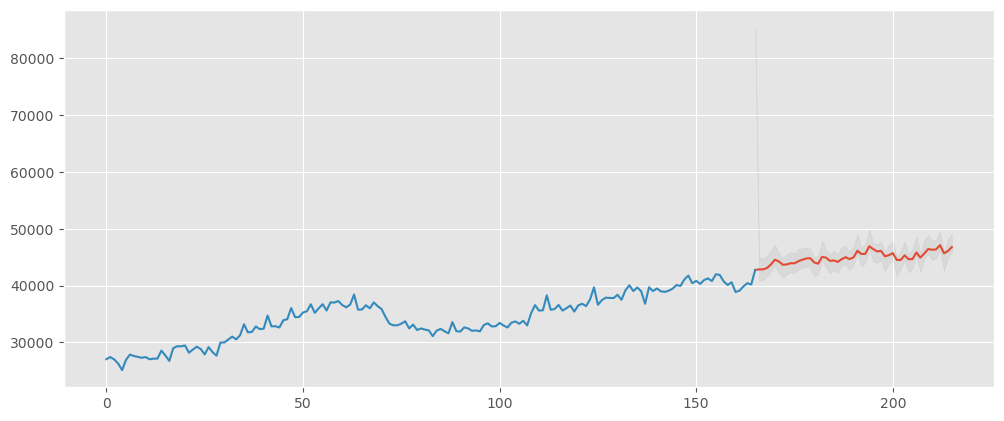

In [1233]:
wage_fc = wage_model13.get_prediction().summary_frame()[:50]
wage_forecast =  wage_data['wage_const_season_correct'].tail(1).append(wage_fc['mean'], ignore_index=True)
wage_forecast = wage_forecast.cumsum().to_frame()
wage_forecast = wage_forecast.set_index(pd.Series([i for i in range(165, 216)]))

wage_up=  wage_data['wage_const_season_correct'].tail(1).append(wage_fc['mean_ci_upper'], ignore_index=True)
wage_up = wage_up.to_frame()
wage_up = wage_up.set_index(pd.Series([i for i in range(165, 216)]))

wage_low=  wage_data['wage_const_season_correct'].tail(1).append(wage_fc['mean_ci_lower'], ignore_index=True)
wage_low = wage_low.to_frame()
wage_low = wage_low.set_index(pd.Series([i for i in range(165, 216)]))

plt.figure(figsize=(12,5), dpi=100)
plt.plot(wage_forecast, label='forecast')
plt.plot(wage_data['wage_const_season_correct'], label='actual')
plt.fill_between(wage_low.index, wage_forecast[0]+wage_low[0], wage_forecast[0]+wage_up[0], color='k', alpha=0.05)
plt.show()

### MA-model

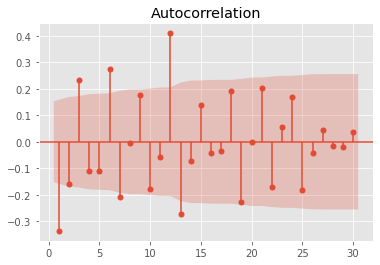

In [212]:
sm.graphics.tsa.plot_acf(wage_data['d1wage'][1:], zero = False, alpha = 0.05, lags = 30)
plt.show()

In [1234]:
ma_wage_3 = ARIMA(wage_data['d1wage'][1:], trend = 'c', order = (0,0,7))
ma_wage_1 = ma_wage_3.fit()
print(ma_wage_1.summary())

                               SARIMAX Results                                
Dep. Variable:                 d1wage   No. Observations:                  165
Model:                 ARIMA(0, 0, 7)   Log Likelihood               -1358.005
Date:                Mon, 30 Jan 2023   AIC                           2734.009
Time:                        12:21:30   BIC                           2761.963
Sample:                             0   HQIC                          2745.357
                                - 165                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         85.6937     44.105      1.943      0.052      -0.751     172.138
ma.L1         -0.4257      0.071     -6.033      0.000      -0.564      -0.287
ma.L2         -0.1228      0.106     -1.154      0.2

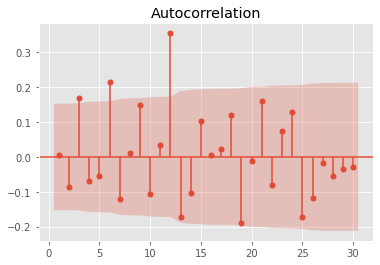

In [760]:
sm.graphics.tsa.plot_acf(ma_wage_1.resid, zero = False, alpha = 0.05, lags = 30)
plt.show()

In [762]:
lag = int(log(len(ma_wage_7.resid)))
sm.stats.acorr_ljungbox(ma_wage_7.resid, lags=[8], model_df = 7, return_df = True)

,lb_stat,lb_pvalue
8,17.912073,0.000023


In [239]:
const = 85.6937 * (1 - sum(ma_wage_7.maparams))
const

120.01844846896253

In [1224]:
ma_wage_1.get_prediction().summary_frame(alpha=0.95).head()

d1wage,mean,mean_se,mean_ci_lower,mean_ci_upper
1,85.693741,1026.857424,21.302820,150.084661
2,-10.897362,968.116362,-71.604819,49.810096
3,220.602681,918.776213,162.989185,278.216177
4,594.825641,918.266489,537.244108,652.407174
5,843.514121,918.051573,785.946065,901.082177


In [1237]:
ma_wage_7 = ma_wage_1

<ipython-input-1236-21805a3b7357>:2: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  wage_forecast =  wage_data['wage_const_season_correct'].tail(1).append(wage_fc['mean'], ignore_index=True)


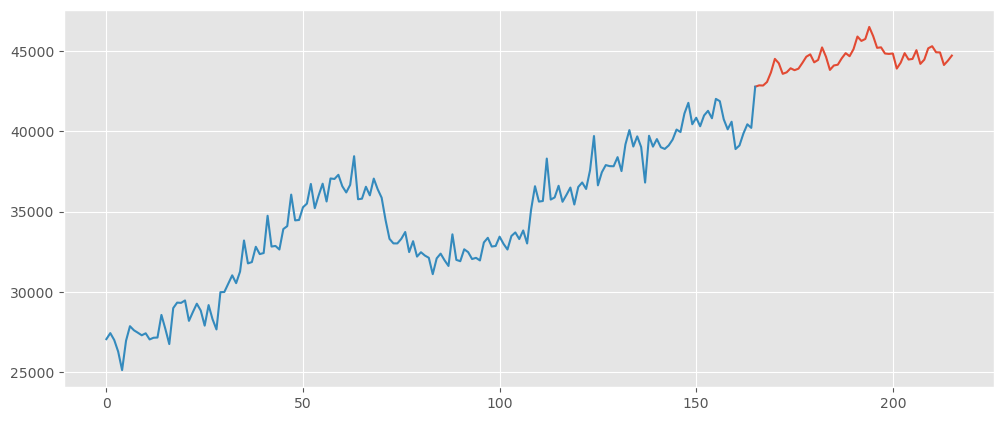

In [1236]:
wage_fc = ma_wage_1.get_prediction().summary_frame()[:50]
wage_forecast =  wage_data['wage_const_season_correct'].tail(1).append(wage_fc['mean'], ignore_index=True)
wage_forecast = wage_forecast.cumsum().to_frame()
wage_forecast = wage_forecast.set_index(pd.Series([i for i in range(165, 216)]))


plt.figure(figsize=(12,5), dpi=100)
plt.plot(wage_forecast, label='forecast')
plt.plot(wage_data['wage_const_season_correct'], label='actual')
plt.show()

<ipython-input-1238-28781dc1c1e4>:2: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  wage_forecast =  wage_data['wage_const_season_correct'].tail(1).append(wage_fc['mean'], ignore_index=True)
<ipython-input-1238-28781dc1c1e4>:6: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  wage_up=  wage_data['wage_const_season_correct'].tail(1).append(wage_fc['mean_ci_upper'], ignore_index=True)
<ipython-input-1238-28781dc1c1e4>:10: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  wage_low=  wage_data['wage_const_season_correct'].tail(1).append(wage_fc['mean_ci_lower'], ignore_index=True)


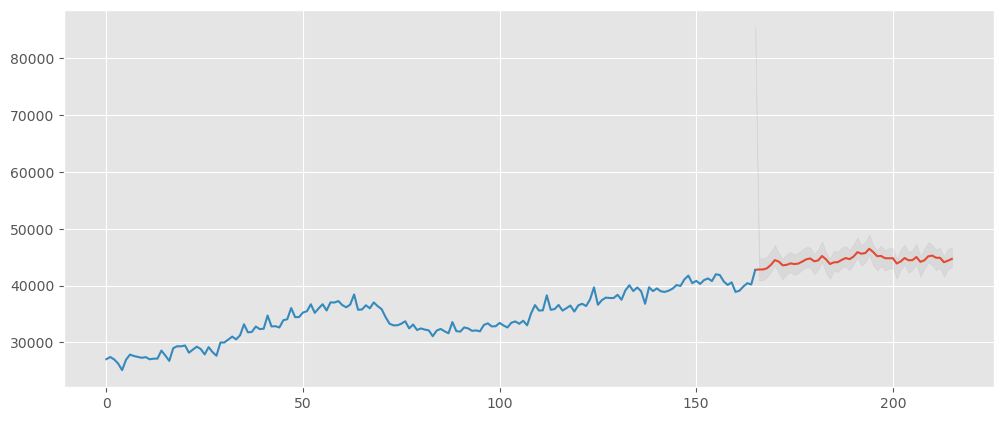

In [1238]:
wage_fc = ma_wage_7.get_prediction().summary_frame()[:50]
wage_forecast =  wage_data['wage_const_season_correct'].tail(1).append(wage_fc['mean'], ignore_index=True)
wage_forecast = wage_forecast.cumsum().to_frame()
wage_forecast = wage_forecast.set_index(pd.Series([i for i in range(165, 216)]))

wage_up=  wage_data['wage_const_season_correct'].tail(1).append(wage_fc['mean_ci_upper'], ignore_index=True)
wage_up = wage_up.to_frame()
wage_up = wage_up.set_index(pd.Series([i for i in range(165, 216)]))

wage_low=  wage_data['wage_const_season_correct'].tail(1).append(wage_fc['mean_ci_lower'], ignore_index=True)
wage_low = wage_low.to_frame()
wage_low = wage_low.set_index(pd.Series([i for i in range(165, 216)]))

plt.figure(figsize=(12,5), dpi=100)
plt.plot(wage_forecast, label='forecast')
plt.plot(wage_data['wage_const_season_correct'], label='actual')
plt.fill_between(wage_low.index, wage_forecast[0]+wage_low[0], wage_forecast[0]+wage_up[0], color='k', alpha=0.05)
plt.show()

### ARMA

In [10]:
pmdarima.arima.auto_arima(wage_data['d1wage'][1:], start_q = 0, max_q = 0, seasonal=False, test = 'adf', with_intercept = False)

NameError: name 'pmdarima' is not defined

In [11]:
sm.tsa.stattools.arma_order_select_ic(wage_data['d1wage'][1:], max_ar = 4, max_ma = 4, trend = 'c') 

C:\Users\Olga\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Olga\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Olga\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Olga\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Olga\anaconda3\lib\site-packages\statsmodels\base\model.py:6

{'bic':              0            1            2            3            4
 0  2768.263102  2742.127954  2747.056026  2748.921492  2752.575803
 1  2752.947007  2747.193965  2750.313633  2753.048744  2754.737852
 2  2740.950790  2745.282361  2750.123909  2741.424837  2746.088504
 3  2745.307687  2750.346643  2755.442479  2746.138373  2751.170695
 4  2750.069601  2754.795713  2753.662747  2751.185204  2756.196325,
 'bic_min_order': (2, 0)}

In [13]:
from statsmodels.tsa.arima.model import ARIMA
arima_model = ARIMA(wage_data['d1wage'][1:], trend = 'c', order = (2,0,1))
arima_model = arima_model.fit()
print(arima_model.summary())

                               SARIMAX Results                                
Dep. Variable:                 d1wage   No. Observations:                  165
Model:                 ARIMA(2, 0, 1)   Log Likelihood               -1359.876
Date:                Mon, 30 Jan 2023   AIC                           2729.753
Time:                        17:13:59   BIC                           2745.282
Sample:                             0   HQIC                          2736.057
                                - 165                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         95.1991     43.312      2.198      0.028      10.308     180.090
ar.L1         -0.6280      0.282     -2.228      0.026      -1.181      -0.075
ar.L2         -0.3786      0.114     -3.312      0.0

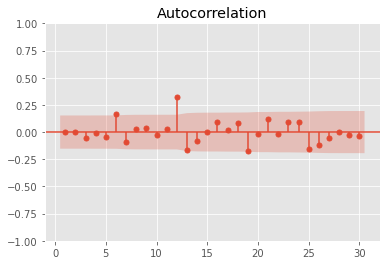

In [14]:
sm.graphics.tsa.plot_acf(arima_model.resid, zero = False, alpha = 0.05, lags = 30)
plt.show()

In [15]:
lag = int(log(len(arima_model.resid)))
sm.stats.acorr_ljungbox(arima_model.resid, lags = [lag], model_df = 3, return_df = True)

,lb_stat,lb_pvalue
5,0.941338,0.624584


In [16]:
const = 95.1991 * (1 - sum(arima_model.arparams))/(1 + sum(arima_model.maparams))
const

160.16252333833836

<ipython-input-793-96758aa335e7>:2: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  wage_forecast =  wage_data['wage_const_season_correct'].tail(1).append(wage_fc['mean'], ignore_index=True)


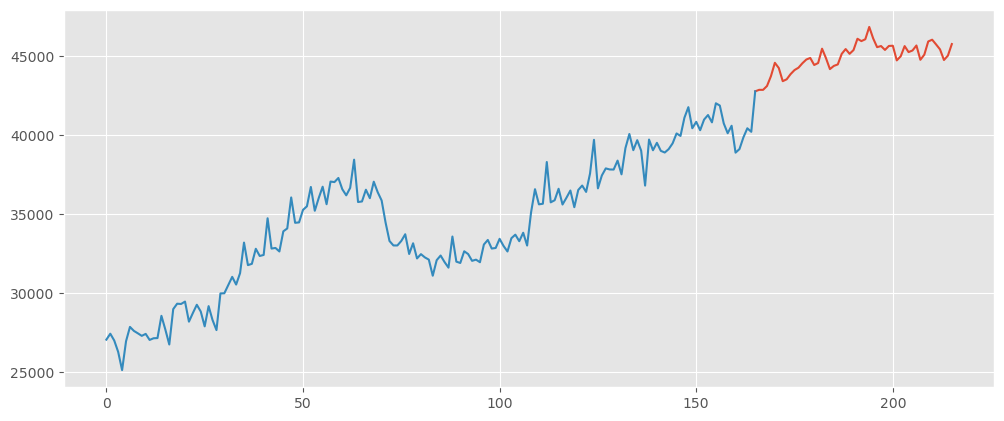

In [793]:
wage_fc = arima_model.get_prediction().summary_frame()[:50]
wage_forecast =  wage_data['wage_const_season_correct'].tail(1).append(wage_fc['mean'], ignore_index=True)
wage_forecast = wage_forecast.cumsum().to_frame()
wage_forecast = wage_forecast.set_index(pd.Series([i for i in range(165, 216)]))


plt.figure(figsize=(12,5), dpi=100)
plt.plot(wage_forecast, label='forecast')
plt.plot(wage_data['wage_const_season_correct'], label='actual')
plt.show()

In [37]:
wage_fc = arima_model.get_prediction().summary_frame()[:50]
wage_forecast =  wage_data['wage_const_season_correct'].tail(1).append(wage_fc['mean'], ignore_index=True)
wage_forecast = wage_forecast.cumsum().to_frame()
wage_forecast = wage_forecast.set_index(pd.Series([i for i in range(165, 216)]))

wage_up=  wage_fc['mean_ci_upper']
wage_up = wage_up.to_frame()
wage_up = wage_up.set_index(pd.Series([i for i in range(166, 216)]))

wage_low=  wage_fc['mean_ci_lower']
wage_low = wage_low.to_frame()
wage_low = wage_low.set_index(pd.Series([i for i in range(166, 216)]))


<ipython-input-37-9355aca24656>:2: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  wage_forecast =  wage_data['wage_const_season_correct'].tail(1).append(wage_fc['mean'], ignore_index=True)


In [38]:
m = pd.DataFrame()
m['fc'] = wage_forecast[0]
m['up'] = wage_up
m['low'] = wage_low
m.to_excel('wage_prediction2.xlsx')

In [36]:
wage_fc = arima_model.get_prediction().summary_frame()[:50]
wage_fc

d1wage,mean,mean_se,mean_ci_lower,mean_ci_upper
1,95.199065,1030.054727,-1923.671103,2114.069233
2,-1.590856,966.664617,-1896.218691,1893.036979
3,245.192263,916.140819,-1550.410747,2040.795273
4,620.421647,914.420495,-1171.809591,2412.652884
5,845.835531,914.356788,-946.270843,2637.941906
6,-330.188414,914.354422,-2122.290150,1461.913323
7,-831.680155,914.354334,-2623.781720,960.421410
8,117.653545,914.354331,-1674.448013,1909.755104
9,330.273453,914.354331,-1461.828105,2122.375011
10,255.130114,914.354331,-1536.971444,2047.231672
